### Parameter generator:

Author: Betsy Landells

This notebook allows you to generate best fit parameters for the drift model. Using simulated data for 9 different scenarios (3 cell types X 3 pressures), best fit parameters are generated for t(r), and this is inverted and use to give r(t). Commissioning data requires taking time stamps t ($t_{calo} - t_{anode}$) and converting them to a radius with a given uncertainty $\sigma_r$

In [1]:
### IMPORTS

import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.odr import ODR, Model, Data, RealData
from scipy import optimize
from scipy import linalg
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from uncertainties import unumpy
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm
import pandas as pd

Welcome to JupyROOT 6.22/00


In [ ]:
from iminuit import Minuit

In [ ]:
from scipy.stats import chi2

In [2]:
import csv

### Importing data

Regions are divided as follows:
- **CT** for centre cell, single quarter
- **TLL**, top left cell, top left quarter, representing the cell corner case 
- **TLR**, top left cell, top right quarter, representing any edge cell.

In [3]:
def unpack(cell_region):
        xs = []
        ys = []
        ts = []
        errts = []
        for drift_times in cell_region.dtimes:
            xs.append(drift_times.xs)
            ys.append(drift_times.ys)
            ts.append(drift_times.dtime)
            errts.append(drift_times.errdtime)
        return xs, ys, ts, errts

In [4]:
class Cell:
    def __init__(self, region):
        unpacked_region = unpack(region)
        self.x = np.array(unpacked_region[0])
        self.y = np.array(unpacked_region[1])
        self.t = np.array(unpacked_region[2])
        self.errt = np.array(unpacked_region[3])
        self.r = np.sqrt(np.array(unpacked_region[0])**2 + np.array(unpacked_region[1])**2)
        

In [5]:
CTL850 = Cell(ROOT.TFile.Open("summaryCTL850.root"))
CTL880 = Cell(ROOT.TFile.Open("summaryCTL880.root"))
CTL910 = Cell(ROOT.TFile.Open("summaryCTL910.root"))
TLL850 = Cell(ROOT.TFile.Open("summaryTLL850.root"))
TLL880 = Cell(ROOT.TFile.Open("summaryTLL880.root"))
TLL910 = Cell(ROOT.TFile.Open("summaryTLL910.root"))
TLR850 = Cell(ROOT.TFile.Open("summaryTLR850.root"))
TLR880 = Cell(ROOT.TFile.Open("summaryTLR880.root"))
TLR910 = Cell(ROOT.TFile.Open("summaryTLR910.root"))

In [6]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
cell_names = ["CTL850", "CTL880", "CTL910", "TLL850", "TLL880", "TLL910", "TLR850", "TLR880", "TLR910"]


#### Fitting distance to time

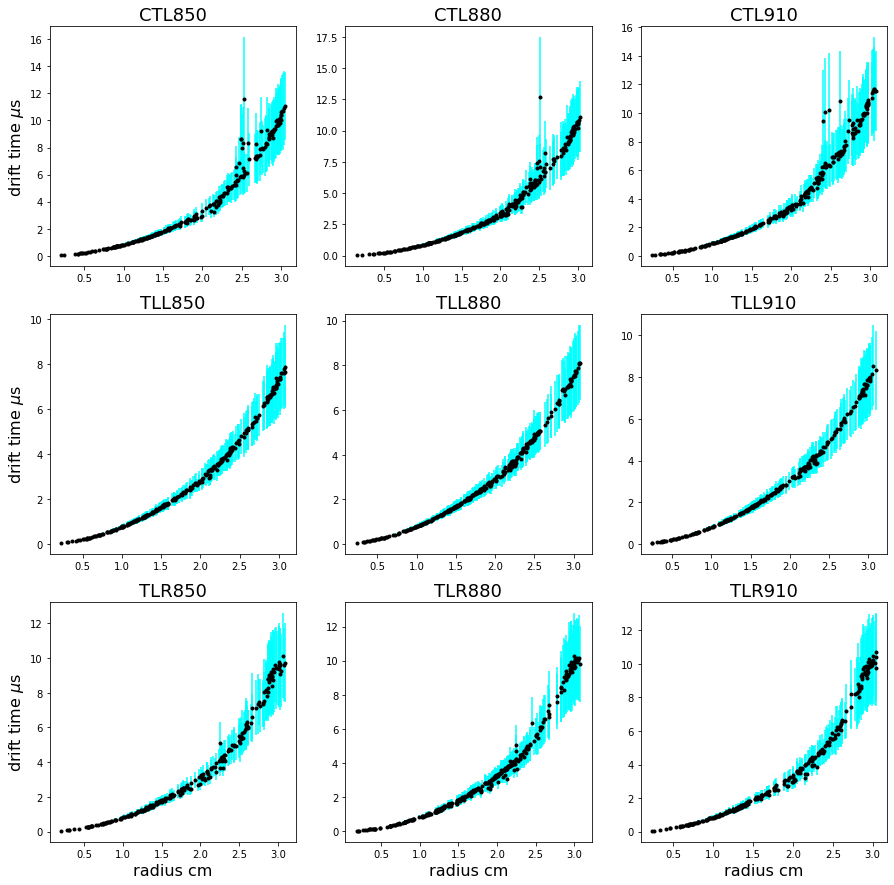

In [7]:
#plot 9 images of the 9 regions
figs, axs = plt.subplots(3,3, figsize=(15,15))
count = 0
for i in range(3):
    for j in range(3):
        label = cell_names[count]
        axs[i,j].errorbar(regions[count].r,np.array(regions[count].t)/1e-6,yerr=np.array(regions[count].errt)/1e-6,fmt='.',ecolor = 'cyan',color='black')
        axs[i,j].set_title(label,fontsize=18)
        axs[i,0].set_ylabel(r'drift time $\mu$s',fontsize=16)
        axs[2,j].set_xlabel('radius cm',fontsize=16)

        count += 1

Drift time equation as a function of radial distance:
$$t(r) = \frac{a \times r}{r^b}$$

In [8]:
def trialfunc(r,a,b):
    """ A function that calculates time from distance"""
    denom = r**b
    return a*r / denom

**initial guesses p0, given by Yorck Ramaschers:**

$0<r<2.2$, a = $1\times 10^{-6}$, b = $-0.9$

$2.2<r<3.5$, a = $1\times 10^{-6}$, b = $-2$


In [9]:
a_guess = 1e-6
b_guess=-0.9 #for 0 to x=2.2
b_guess2=-2.0 #for x>2.2

In [10]:
def perform_fit(region,cutoff):
    
    """THIS FUNCTION FITS SIMULATED DATA: T AS A FUNCTION OF R 
    
    PROVIDES CURVE FIT PARAMETERS FOR r < cutoff and r >= cutoff"""
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    #a, b for r<cut off
    popt,pcov = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    perr = np.sqrt(np.diag(pcov))
    
    #a2, b2 for r>cut off
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess],sigma=err_up)
    perr2 = np.sqrt(np.diag(pcov2))

    return popt,perr,popt2,perr2

**Inverse function:** Radial distance as a function of drift time:
$$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$$

In [11]:
def invertfunc(t,a,b):
    
    """ The inverse function which calculates radius as a function of time"""
    power = (1/(1-b))
    
    return (t/a)**power

**Error propagation:** 
$$\begin{equation}
\sigma_r^2 = \sigma_a^2(\frac{\partial r}{\partial a})^2 + \sigma_b^2(\frac{\partial r}{\partial b})^2 + \sigma_t^2(\frac{\partial r}{\partial t})^2
\end{equation}$$


In [12]:
def error_propagation(ts,errts,a,erra,b,errb):
    
    """ Generates r and delta r based on uncertainty in t, a, b"""
    
    t_tuple = unumpy.uarray(ts, errts)
    a_tuple = unumpy.uarray(a, erra)
    b_tuple = unumpy.uarray(b, errb)
    r = (t_tuple/a_tuple)**(1/(1-b_tuple))
    err = unumpy.std_devs(r)
    val = unumpy.nominal_values(r)
    return err, val

**Reduced chi squared as a measure of goodness-of-fit:**

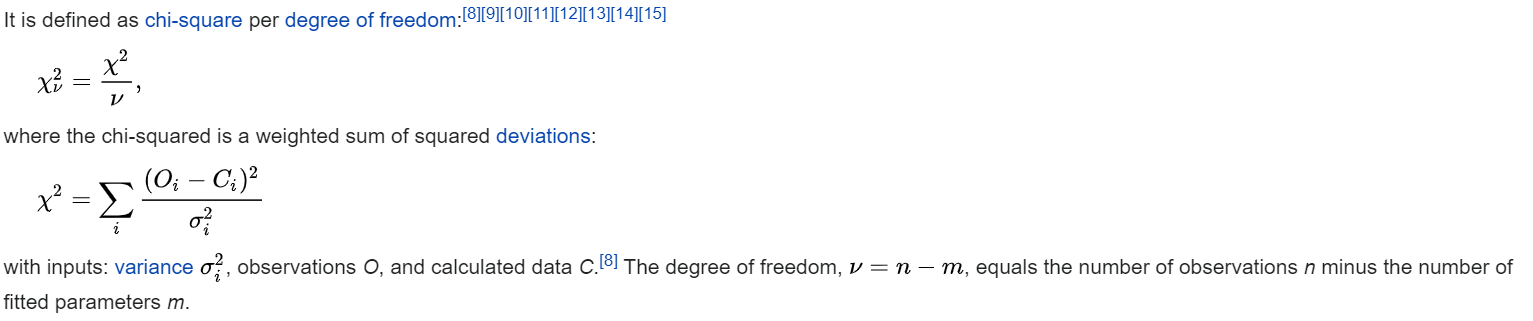

In [166]:
def chi2_reduce(region,lo_cutoff):
    
    #get params from curve fit
    popt,perr,popt2,perr2 = perform_fit(region,lo_cutoff)
    
    
    """Reduced Chi squared (Chi squared per degree of freedom) for r<cut off"""
   
    r_low = np.array(region.r)[region.r<lo_cutoff]
    time_low = np.array(region.t)[region.r<lo_cutoff]
    err_low = np.array(region.errt)[region.r<lo_cutoff]
    
    #get predicted radii and errors from inverse function
    errs,vals = error_propagation(time_low,err_low,popt[0],perr[0],popt[1],perr[1])

    
    #plt.errorbar(vals,time_low,xerr=errs,fmt='.',label='predicted')
    #plt.plot(r_low,time_low,'.',label='data')
    #plt.legend()
    #plt.title('cut off r<{}'.format(lo_cutoff))
    #plt.show()
    
    #chi squared statistic (using standard error instead of variance)
    #chi2_low = sum(((vals-r_low)**2)/(np.sqrt(errs/500)))
    chi2_low = sum(((vals-r_low)**2)/errs)#(np.sqrt(errs/500)))


    
    
    """Reduced Chi squared (Chi squared per degree of freedom) for r >= cut off"""

    r_hi = np.array(region.r)[region.r>=lo_cutoff]
    time_hi = np.array(region.t)[region.r>=lo_cutoff]
    err_hi = np.array(region.errt)[region.r>=lo_cutoff]
        
    #get predicted radii and errors from inverse function
    errs,vals = error_propagation(time_hi,err_hi,popt2[0],perr2[0],popt2[1],perr2[1])
    
    #plt.errorbar(vals,time_hi,xerr=errs,fmt='.',label='predicted')
    #plt.plot(r_hi,time_hi,'.',label='data')
    #plt.legend()
    #plt.title('cut off r>{}'.format(lo_cutoff))
    #plt.show()

    #chi squared statistic (using standard error instead of variance)
    #chi2_hi = sum(((vals-r_hi)**2)/(np.sqrt(errs/500)))
    chi2_hi = sum(((vals-r_hi)**2)/errs)

    return chi2_low/len(r_low), chi2_hi/len(r_hi) #print('chi2/DOF:', res/len(r_low)), print(popt,perr,popt2,perr2)

In [167]:
chi2_reduce(CTL880,2.2)

(0.007420706280811651, 0.022390432591704038)

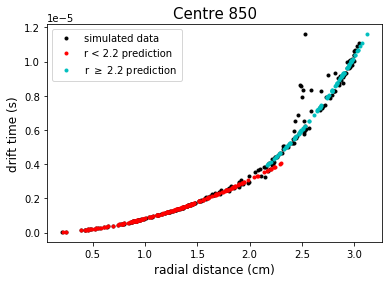

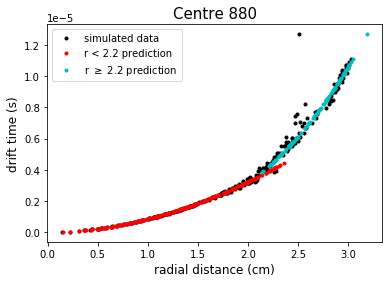

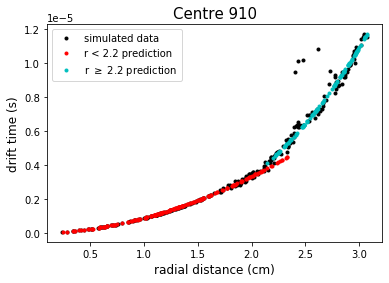

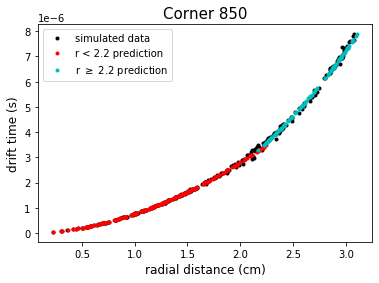

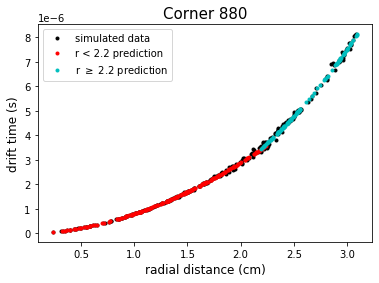

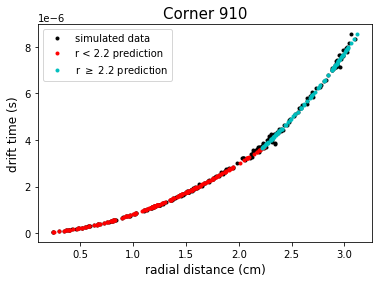

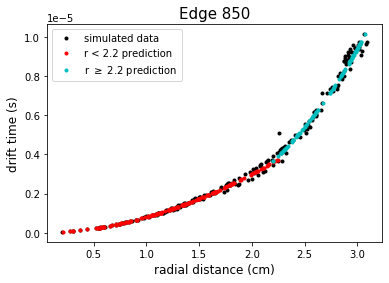

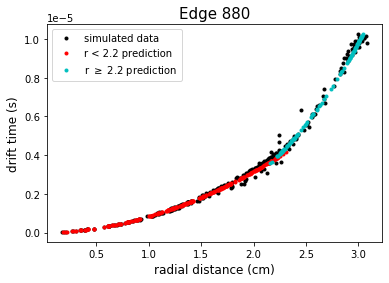

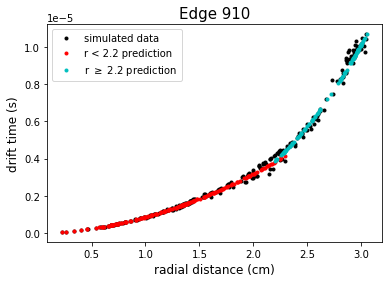

In [175]:
f2 = open('drift_parameters.csv','w')
f2.write('{} {} {} {} {} {} {} {}\n'.format('a', 'erra', 'b', 'errb', 'a2', 'erra2', 'b2', 'errb2'))
cutoff=2.2
count = 0
cell_names = ["Centre 850", "Centre 880", "Centre 910", "Corner 850", "Corner 880", "Corner 910", "Edge 850", "Edge 880", "Edge 910"]

for region in regions:
    popt,perr,popt2,perr2 = perform_fit(region,cutoff)
    chi_lo,chi_hi = chi2_reduce(region,cutoff)
    plt.plot(region.r,region.t,'k.',label='simulated data')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)<cutoff],popt[0],popt[1]),np.array(region.t)[np.array(region.r)<cutoff],'r.',label='r < 2.2 prediction')
    plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=cutoff],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=cutoff],'c.',label=r'r $\geq$ 2.2 prediction')
    plt.legend()
    #plt.annotate(r'$\chi^2$:{}'.format(chi_lo+chi_hi),(2,0))
    plt.title(cell_names[count],fontsize=15)
    plt.xlabel('radial distance (cm)',fontsize=12)
    plt.ylabel('drift time (s)',fontsize=12)
    plt.show()
    count+=1
    f2.write('{} {} {} {} {} {} {} {}\n'.format(popt[0],perr[0],popt[1],perr[1],popt2[0],perr2[0],popt2[1],perr2[1]))

#### Error propagation

In [101]:
def perform_fit_err(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]

    popt1,pcov1 = curve_fit(trialfunc,r_low,time_low+err_low,p0=[a_guess,b_guess])#,sigma=err_low)
    popt2,pcov2 = curve_fit(trialfunc,r_low,time_low,p0=[a_guess,b_guess],sigma=err_low)
    popt3,pcov3 = curve_fit(trialfunc,r_low,time_low-err_low,p0=[a_guess,b_guess])#,sigma=err_low)

    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))


    return popt1,perr1,popt2,perr2,popt3,perr3

In [102]:
def perform_fit_err_high(region,cutoff):
    
    r_low = np.array(region.r)[region.r<cutoff]
    r_up = np.array(region.r)[region.r>=cutoff]
    time_low = np.array(region.t)[region.r<cutoff]
    time_up = np.array(region.t)[region.r>=cutoff]
    err_low = np.array(region.errt)[region.r<cutoff]
    err_up = np.array(region.errt)[region.r>=cutoff]
    
    popt1,pcov1 = curve_fit(trialfunc,r_up,time_up+err_up,p0=[a_guess,b_guess])#,sigma=err_low)
    popt2,pcov2 = curve_fit(trialfunc,r_up,time_up,p0=[a_guess,b_guess])#,sigma=err_up)
    popt3,pcov3 = curve_fit(trialfunc,r_up,time_up-err_up,p0=[a_guess,b_guess])#,sigma=err_low)
    
    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    perr3 = np.sqrt(np.diag(pcov3))
    
    return popt1,perr1,popt2,perr2,popt3,perr3

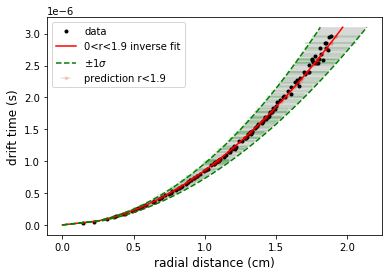

In [165]:
tfine=np.linspace(0,3.1e-6)
##need to choose a tfine that corresponds to 1.9

tfine2=np.linspace(4e-6,12e-6)
popt1,perr1,popt2,perr2,popt3,perr3 = perform_fit_err(CTL880,1.9)

region=CTL880
err1,val1 = error_propagation(np.array(region.t)[region.r < 1.9],np.array(region.errt)[region.r < 1.9],popt2[0],perr2[0],popt2[1],perr2[1])
plt.errorbar(val1,np.array(region.t)[region.r < 1.9],xerr=err1,fmt='.',ecolor = 'green',alpha=0.13,color='red',label='prediction r<1.9')

plt.plot(CTL880.r[CTL880.r<1.9],CTL880.t[CTL880.r<1.9],'k.',label='data')
plt.plot(invertfunc(tfine,popt2[0],popt2[1]),tfine,'r-',label='0<r<1.9 inverse fit')
plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,color='green',linestyle='--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,color='green',linestyle='--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine,popt1[0],popt1[1])
y2 = invertfunc(tfine,popt3[0],popt3[1])
#x = 
plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.3)
#plt.axvline(x=0.05,color='red',label='MAX r=3.111')

#plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
plt.show()

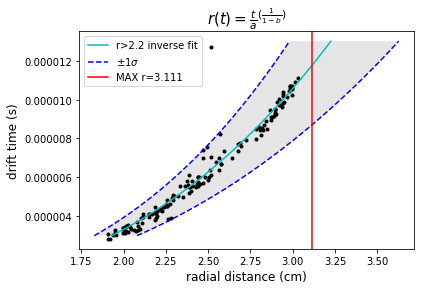

In [128]:
tfine2=np.linspace(3e-6,13e-6)
popt4,perr4,popt5,perr5,popt6,perr6 = perform_fit_err_high(CTL880,1.9)
#popt1,perr1,popt2,perr2,popt3,perr3 = perform_fit_err(CTL880,2.2)
plt.plot(CTL880.r[CTL880.r>=1.9],CTL880.t[CTL880.r>=1.9],'k.')#,label='data')
plt.plot(invertfunc(tfine2,popt5[0],popt5[1]),tfine2,'c-',label='r>2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'b--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine2,popt6[0],popt6[1]),tfine2,'b--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine2,popt4[0],popt4[1])
y2 = invertfunc(tfine2,popt6[0],popt6[1])
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.2)

plt.axvline(x=np.sqrt(2.2**2+2.2**2),color='red',label='MAX r=3.111')

plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=15)
plt.legend()
#plt.xlim([1.7,3.112])
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
plt.show()

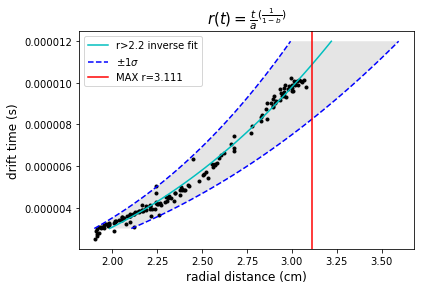

In [121]:
tfine2=np.linspace(3e-6,12e-6)
popt4,perr4,popt5,perr5,popt6,perr6 = perform_fit_err_high(TLR880,1.9)
#popt1,perr1,popt2,perr2,popt3,perr3 = perform_fit_err(CTL880,2.2)
plt.plot(TLR880.r[TLR880.r>=1.9],TLR880.t[TLR880.r>=1.9],'k.')#,label='data')
plt.plot(invertfunc(tfine2,popt5[0],popt5[1]),tfine2,'c-',label='r>2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'b--',label=r'$\pm 1\sigma$')
plt.plot(invertfunc(tfine2,popt6[0],popt6[1]),tfine2,'b--')#,label=r'$-1\sigma$')
y1 = invertfunc(tfine2,popt4[0],popt4[1])
y2 = invertfunc(tfine2,popt6[0],popt6[1])
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.2)

plt.axvline(x=np.sqrt(2.2**2+2.2**2),color='red',label='MAX r=3.111')

plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=15)
plt.legend()
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
plt.show()

In [145]:
plt.rcParams['axes.formatter.limits'] = [-5,6]

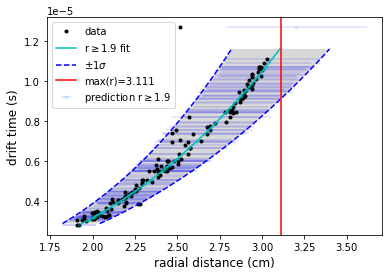

In [163]:
region=CTL880
popt,perr,popt2,perr2 = perform_fit(region,1.9)
#err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 1.9],np.array(region.errt)[region.r >= 1.9],popt2[0],perr2[0],popt2[1],perr2[1])
plt.plot(region.r[region.r >= 1.9],np.array(region.t)[region.r >= 1.9],'k.',label='data')
#plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
plt.errorbar(val2,np.array(region.t)[region.r >= 1.9],xerr=err2,fmt='.',ecolor = 'b',alpha=0.13,color='c',label=r'prediction r$\geq$1.9')
plt.legend(loc='upper left')
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(2.9e-6,11.6e-6)
#plt.plot(r_CTL880[r_CTL880<2.2],drift_CTL880[r_CTL880<2.2],'k.',label='data')
#plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,'g--',label=r'$\pm 1\sigma$')
#plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,'g--')#,label=r'$-1\sigma$')
#y1 = invertfunc(tfine,popt1[0],popt1[1])
#y2 = invertfunc(tfine,popt3[0],popt3[1])
#x = 
#plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.9)


#plt.plot(val1+err1,np.array(region.t)[region.r < 2.2],'b.')#,label='prediction r<2.2')

#plt.plot(val1-err1,np.array(region.t)[region.r < 2.2],'b.',label='err r<2.2')

#plt.plot(val2+err2,np.array(region.t)[region.r >= 2.2],'g.',label='err r>2.2')
#plt.plot(val2-err2,np.array(region.t)[region.r >= 2.2],'g.')#,label='err r<2.2')

#plt.plot(invertfunc(tfine,popt[0],popt[1]),tfine,'r-',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r$\geq$1.9 fit')


popt1,pcov1 = curve_fit(trialfunc,val2+err2,np.array(region.t)[region.r >= 1.9],p0=[a_guess,b_guess])
popt4,pcov4 = curve_fit(trialfunc,val2-err2,np.array(region.t)[region.r >= 1.9],p0=[a_guess,b_guess])
plt.plot(invertfunc(tfine2,popt1[0],popt1[1]),tfine2,'b--',label=r'$\pm 1\sigma$')#''0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'b--')#,label='0<r<2.2 inverse fit')

y1 = invertfunc(tfine2,popt1[0],popt1[1])
y2 = invertfunc(tfine2,popt4[0],popt4[1])
#x = 
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.3)

#plt.plot()
#plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.axvline(x=np.sqrt(2.2**2+2.2**2),color='red',label='max(r)=3.111')

plt.legend()

plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
#plt.show()
#plt.title('Inverse fit with error bars'+' '+str(label))
#plt.ylabel(r'drift time (s)')
#plt.xlabel('radial distance (cm)')
#print(err1,err2)
plt.show()

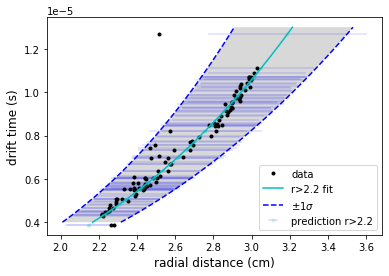

In [148]:
region=CTL880
popt,perr,popt2,perr2 = perform_fit(region,1.9)
#err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 1.9],np.array(region.errt)[region.r >= 1.9],popt2[0],perr2[0],popt2[1],perr2[1])
plt.plot(region.r[region.r >= 2.2],np.array(region.t)[region.r >= 2.2],'k.',label='data')
#plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'b',alpha=0.13,color='c',label='prediction r>2.2')
plt.legend(loc='upper left')
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,13e-6)
#plt.plot(r_CTL880[r_CTL880<2.2],drift_CTL880[r_CTL880<2.2],'k.',label='data')
#plt.plot(invertfunc(tfine,popt1[0],popt1[1]),tfine,'g--',label=r'$\pm 1\sigma$')
#plt.plot(invertfunc(tfine,popt3[0],popt3[1]),tfine,'g--')#,label=r'$-1\sigma$')
#y1 = invertfunc(tfine,popt1[0],popt1[1])
#y2 = invertfunc(tfine,popt3[0],popt3[1])
#x = 
#plt.fill_betweenx(tfine, y1, y2, facecolor="gray", alpha=0.9)


#plt.plot(val1+err1,np.array(region.t)[region.r < 2.2],'b.')#,label='prediction r<2.2')

#plt.plot(val1-err1,np.array(region.t)[region.r < 2.2],'b.',label='err r<2.2')

#plt.plot(val2+err2,np.array(region.t)[region.r >= 2.2],'g.',label='err r>2.2')
#plt.plot(val2-err2,np.array(region.t)[region.r >= 2.2],'g.')#,label='err r<2.2')

#plt.plot(invertfunc(tfine,popt[0],popt[1]),tfine,'r-',label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 fit')


popt1,pcov1 = curve_fit(trialfunc,val2+err2,np.array(region.t)[region.r >= 2.2],p0=[a_guess,b_guess])
popt4,pcov4 = curve_fit(trialfunc,val2-err2,np.array(region.t)[region.r >= 2.2],p0=[a_guess,b_guess])
plt.plot(invertfunc(tfine2,popt1[0],popt1[1]),tfine2,'b--',label=r'$\pm 1\sigma$')#''0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'b--')#,label='0<r<2.2 inverse fit')

y1 = invertfunc(tfine2,popt1[0],popt1[1])
y2 = invertfunc(tfine2,popt4[0],popt4[1])
#x = 
plt.fill_betweenx(tfine2, y1, y2, facecolor="gray", alpha=0.3)

#plt.plot()
#plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)',fontsize=12)
plt.ylabel('drift time (s)',fontsize=12)
#plt.show()
#plt.title('Inverse fit with error bars'+' '+str(label))
#plt.ylabel(r'drift time (s)')
#plt.xlabel('radial distance (cm)')
#print(err1,err2)
plt.show()

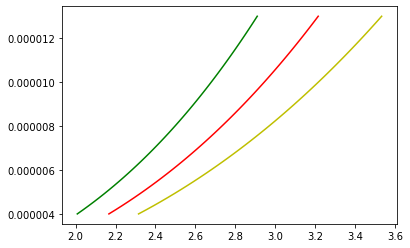

In [130]:
plt.plot(invertfunc(tfine2,popt1[0],popt1[1]),tfine2,'y-',label='+/- 1sigma')#''0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),tfine2,'g-')#,label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'r-',label='r>2.2 fit')


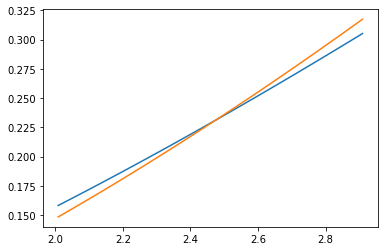

In [131]:
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),abs(invertfunc(tfine2,popt4[0],popt4[1])-invertfunc(tfine2,popt2[0],popt2[1])))
plt.plot(invertfunc(tfine2,popt4[0],popt4[1]),abs(invertfunc(tfine2,popt2[0],popt2[1])-invertfunc(tfine2,popt1[0],popt1[1])))

In [79]:
def inversefit_plot(region,label):
    popt,perr,popt2,perr2 = perform_fit(region,2.2)
    err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
    err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
    plt.errorbar(region.r,np.array(region.t),yerr=np.array(region.errt),fmt='.',ecolor = 'pink',color='red',label='data')
    plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
    plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'green',alpha=0.2,color='black',label='prediction r>2.2')
    plt.legend(loc='upper left')
    plt.title('Inverse fit with error bars'+' '+str(label))
    plt.ylabel(r'drift time (s)')
    plt.xlabel('radial distance (cm)')
    #print(err1,err2)
    plt.show()

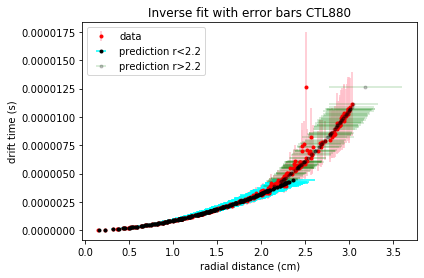

In [80]:
inversefit_plot(CTL880,'CTL880')

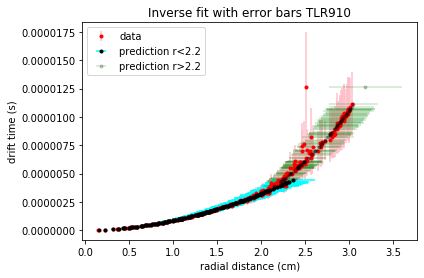

In [82]:
popt,perr,popt2,perr2 = perform_fit(region,2.2)
err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
plt.errorbar(region.r,np.array(region.t),yerr=np.array(region.errt),fmt='.',ecolor = 'pink',color='red',label='data')
plt.errorbar(val1,np.array(region.t)[region.r < 2.2],xerr=err1,fmt='.',ecolor = 'cyan',color='black',label='prediction r<2.2')
plt.errorbar(val2,np.array(region.t)[region.r >= 2.2],xerr=err2,fmt='.',ecolor = 'green',alpha=0.2,color='black',label='prediction r>2.2')
plt.legend(loc='upper left')
plt.title('Inverse fit with error bars'+' '+str(label))
plt.ylabel(r'drift time (s)')
plt.xlabel('radial distance (cm)')
#print(err1,err2)
plt.show()

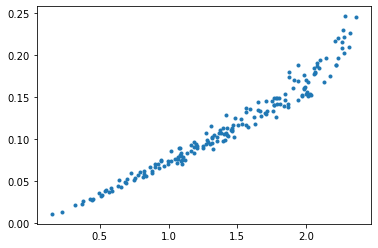

In [84]:
plt.plot(val1,err1,'.')

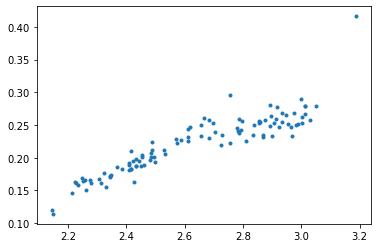

In [85]:
plt.plot(val2,err2,'.')

In [23]:
################################################## getting best fit parameters from minuit and proving independece 

In [24]:
from probfit import Chi2Regression

In [25]:
trialfunc

<function __main__.trialfunc(r, a, b)>

((array([1.06696234, 1.17845492, 1.36290896, 1.47773794, 1.37239549,
         0.64693043, 0.36436417, 0.58930868, 1.0080327 , 0.82251093,
         1.2099565 , 1.77471982, 0.88095241, 1.5301425 , 1.10877032,
         0.90695642, 0.48951656, 1.46298481, 0.79593712, 1.41374457,
         1.75439871, 0.86707639, 1.20945416, 1.30782153, 1.2816018 ,
         0.92846948, 1.32833954, 1.02569539, 0.53401982, 1.40765094,
         0.90017804, 1.60553801, 1.47564791, 0.69341865, 0.4480546 ,
         1.08327435, 1.69777745, 1.32362664, 0.58079149, 0.92409737,
         0.5121113 , 1.09680692, 1.427746  , 0.31205211, 0.3762826 ,
         1.13665374, 1.18586559, 0.4403473 , 1.35236682, 1.58336178,
         1.36942691, 1.46577166, 0.99240296, 1.64959474, 0.94726718,
         1.10398439, 1.33626362, 1.49875451, 1.40148339, 1.04269572,
         1.44587746, 0.63459968, 0.2217289 , 1.09821206, 0.55952421,
         1.15198467, 0.7011051 , 1.19175227, 1.16900937, 1.01543345,
         0.94553251, 1.473035  , 1

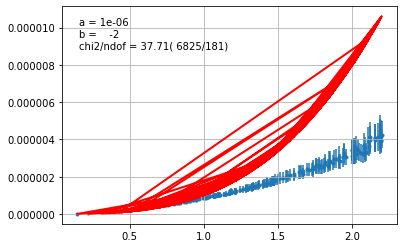

In [26]:
x2reg= Chi2Regression(trialfunc, region.r[region.r<2.2], region.t[region.r<2.2], error=region.errt[region.r<2.2])
x2reg.draw(args={'a':1e-6,'b':-2})

In [36]:
import iminuit

In [95]:
a_guess

1e-06

In [96]:
b_guess,b_guess2

(-0.9, -2.0)

In [37]:
import probfit

In [ ]:
#cut off is found by Chi2 tests

In [97]:
def best_fit(cutoff):
    chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r<cutoff], region.t[region.r<cutoff], region.errt[region.r<cutoff])
    minuit = iminuit.Minuit(chi2, a=a_guess, b=b_guess) # see iminuit tutorial on how to give initial value/range/error
    minuit.migrad()
    vals = minuit.values
    errs = minuit.errors
    chi2_hi = probfit.Chi2Regression(trialfunc, region.r[region.r>=cutoff], region.t[region.r>=cutoff], region.errt[region.r>=cutoff])
    minuit_hi = iminuit.Minuit(chi2_hi, a=a_guess, b=b_guess2) # see iminuit tutorial on how to give initial value/range/error
    minuit_hi.migrad()
    vals_hi = minuit_hi.values
    errs_hi = minuit_hi.errors
    return vals,errs,vals_hi,errs_hi

In [98]:
best_fit(1.9)

/tmp/ipykernel_598/3693129119.py:1: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  best_fit(1.9)


(<ValueView of Minuit at 443cd70>
   a: 8.533068690606196e-07
   b: -0.9011081879386615,
 <ErrorView of Minuit at 443cd70>
   a: 1.0420577963802205e-08
   b: 0.025545703766983036,
 <ValueView of Minuit at 8e52d00>
   a: 4.192666126773892e-07
   b: -1.9295987055019816,
 <ErrorView of Minuit at 8e52d00>
   a: 4.347150530599264e-08
   b: 0.12155101796425133)

In [38]:
iminuit.describe(trialfunc)


['r', 'a', 'b']

In [65]:
chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r<1.9], region.t[region.r<1.9], region.errt[region.r<1.9])
iminuit.describe(chi2)

['a', 'b']

In [66]:
minuit = iminuit.Minuit(chi2, a=1e-6, b=-2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.727                      │         Nfcn = 57 (57 total)         │
│ EDM = 4.92e-08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 0.853e-6  │ 0.010e-6  │            │            │         │         │       │
│ 1 │ b    │  -0.901   │   0.026   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [67]:
print(minuit.values)
print(minuit.errors)


<ValueView of Minuit at 443cd70>
  a: 8.532977991469658e-07
  b: -0.9011476018896774
<ErrorView of Minuit at 443cd70>
  a: 1.0420622803199454e-08
  b: 0.02554699854231376


In [68]:
print(minuit.matrix(correlation=True))


┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 1.000 0.105 │
│ b │ 0.105 1.000 │
└───┴─────────────┘


In [69]:
#they are correlated by 0.343 - correlate less for 0.1

((array([1.06696234, 1.17845492, 1.36290896, 1.47773794, 1.37239549,
         0.64693043, 0.36436417, 0.58930868, 1.0080327 , 0.82251093,
         1.2099565 , 1.77471982, 0.88095241, 1.5301425 , 1.10877032,
         0.90695642, 0.48951656, 1.46298481, 0.79593712, 1.41374457,
         1.75439871, 0.86707639, 1.20945416, 1.30782153, 1.2816018 ,
         0.92846948, 1.32833954, 1.02569539, 0.53401982, 1.40765094,
         0.90017804, 1.60553801, 1.47564791, 0.69341865, 0.4480546 ,
         1.08327435, 1.69777745, 1.32362664, 0.58079149, 0.92409737,
         0.5121113 , 1.09680692, 1.427746  , 0.31205211, 0.3762826 ,
         1.13665374, 1.18586559, 0.4403473 , 1.35236682, 1.58336178,
         1.36942691, 1.46577166, 0.99240296, 1.64959474, 0.94726718,
         1.10398439, 1.33626362, 1.49875451, 1.40148339, 1.04269572,
         1.44587746, 0.63459968, 0.2217289 , 1.09821206, 0.55952421,
         1.15198467, 0.7011051 , 1.19175227, 1.16900937, 1.01543345,
         0.94553251, 1.473035  , 1

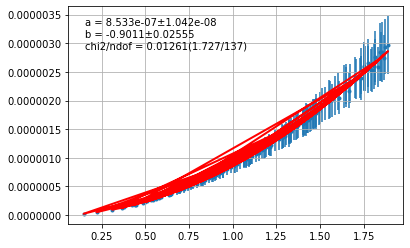

In [70]:
chi2.draw(minuit)

In [99]:
chi2 = probfit.Chi2Regression(trialfunc, region.r[region.r>=1.9], region.t[region.r>=1.9], region.errt[region.r>=1.9])
minuit = iminuit.Minuit(chi2, a=1e-6, b=b_guess2) # see iminuit tutorial on how to give initial value/range/error
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.48                      │         Nfcn = 64 (64 total)         │
│ EDM = 3.77e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  0.42e-6  │  0.04e-6  │            │            │         │         │       │
│ 1 │ b    │   -1.93   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [100]:
minuit.values

<ValueView of Minuit at 9022330>
  a: 4.192666126773892e-07
  b: -1.9295987055019816

In [77]:
print(minuit.matrix(correlation=True))

┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │ 1.000 0.987 │
│ b │ 0.987 1.000 │
└───┴─────────────┘


massively correlated (?)

((array([1.9471473 , 2.11564533, 2.27310183, 2.21415474, 2.25225364,
         2.38799036, 1.90788367, 2.50299739, 2.51894945, 2.44258673,
         2.18841608, 2.54538001, 2.25732716, 2.56135611, 2.67649096,
         2.21597532, 2.19169738, 2.41203494, 2.4536834 , 2.44392423,
         2.44123052, 2.44014565, 2.69122731, 2.28997675, 2.43819366,
         2.38376679, 2.57726357, 2.43520747, 2.42856605, 2.64223971,
         2.39039958, 2.28874322, 2.22987146, 2.2966398 , 2.14975894,
         2.44744266, 2.25555046, 2.16979079, 2.46626893, 2.22391281,
         2.02076868, 2.8952359 , 2.89646077, 2.93947231, 2.8294047 ,
         2.9645681 , 2.94166868, 3.01461159, 2.98450605, 2.90001791,
         2.99582487, 2.89727968, 2.78538433, 2.87839484, 2.93974695,
         2.86891044, 2.89715878, 2.91778709, 2.82027124, 2.8118274 ,
         2.90869236, 2.83891399, 2.94688992, 2.99438947, 2.93226889,
         2.9846035 , 2.86291098, 2.98518844, 2.93878403, 2.9428154 ,
         2.84561245, 2.9210505 , 2

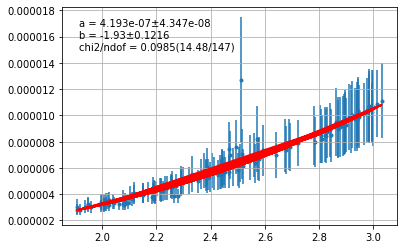

In [78]:
chi2.draw(minuit)

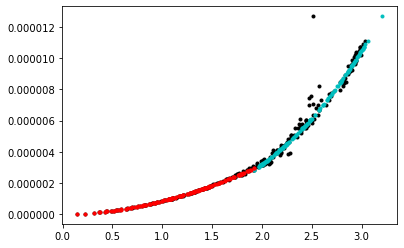

In [63]:
plt.plot(region.r,region.t,'k.')
plt.plot(invertfunc(region.t[region.r>=1.9],4.192666126773892e-07,-1.9295987055019816),region.t[region.r>=1.9],'c.')
plt.plot(invertfunc(region.t[region.r<1.9],8.532977991469658e-07,-0.9011476018896774),region.t[region.r<1.9],'r.')



now do a chi2 on these params to check theyre better

---

Pull plot:
$$\frac{\hat{\chi} - \chi}{\sigma}$$

In [ ]:
def pull_plot(region)
region = CTL850
popt,perr,popt2,perr2 = perform_fit(region,2.2)
err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
pull1 = (val1-region.r[region.r < 2.2])/err1;
pull2 = (val2-region.r[region.r >= 2.2])/err2;
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(region.r[region.r < 2.2],pull1,'c.',label='r < 2.2')
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
ax.set_xlabel('radial distance (cm)')
plt.title('Pull for r<2.2, Corner 850')
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
ax.set_ylim([-1,1])
plt.legend()
         

In [ ]:
popt,perr,popt2,perr2 = perform_fit(region,2.2)
err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])

In [ ]:
#prediction minus truth divided by error
pull1 = (val1-region.r[region.r < 2.2])/err1;

In [ ]:
pull2 = (val2-region.r[region.r >= 2.2])/err2;

In [ ]:
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(region.r[region.r < 2.2],pull1,'c.',label='r < 2.2')
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
ax.set_xlabel('radial distance (cm)')
plt.title('Pull for r<2.2, Corner 850')
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
ax.set_ylim([-1,1])
plt.legend()
         

In [ ]:
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(region.r[region.r >= 2.2],pull2,'c.',label=r'r$\geq$2.2')
ax.hlines(y=0,xmin=2.2,xmax=3.1,linestyles='dashed')
yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
plt.title('Pull for r $\geq$2.2, Corner 850')
ax.set_xlabel('radial distance (cm)')
ax.set_xlabel('radial distance (cm)')
plt.legend()
ax.set_ylim([-1,1])
plt.show()


**distance on the x axis and then measured-fitted on the y axis (basically don't divide through by the uncertainty) but then draw on the line that shows what the uncertainty +/- 1 sigma would be**

In [ ]:
regions = [CTL850, CTL880, CTL910, TLL850, TLL880, TLL910, TLR850, TLR880, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions)):
    popt,perr,popt2,perr2 = perform_fit(regions[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying regions')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='centre')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='corner')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='edge')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

In [ ]:
regions2 = [CTL850, TLL850, TLR850, CTL880, TLL880, TLR880, CTL910, TLL910, TLR910]
a = []
erra = []
b = []
errb = []
a2 = []
erra2 = []
b2 = []
errb2 = []
for i in range(len(regions2)):
    popt,perr,popt2,perr2 = perform_fit(regions2[i],2.2)
    a.append(popt[0])
    erra.append(perr[0])
    b.append(popt[1])
    errb.append(perr[1])
    a2.append(popt2[0])
    erra2.append(perr2[0])
    b2.append(popt2[1])
    errb2.append(perr2[1])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')


ax1.errorbar(a[0:3],b[0:3],xerr=erra[0:3],yerr=errb[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax1.errorbar(a[3:6],b[3:6],xerr=erra[3:6],yerr=errb[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax1.errorbar(a[6:9],b[6:9],xerr=erra[6:9],yerr=errb[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('r<2.2')
ax1.legend()

ax2.errorbar(a2[0:3],b2[0:3],xerr=erra2[0:3],yerr=errb2[0:3],fmt='.',ecolor = 'cyan',color='black',label='850')
ax2.errorbar(a2[3:6],b2[3:6],xerr=erra2[3:6],yerr=errb2[3:6],fmt='.',ecolor = 'pink',color='red',label='880')
ax2.errorbar(a2[6:9],b2[6:9],xerr=erra2[6:9],yerr=errb2[6:9],fmt='.',ecolor = 'lightgreen',color='green',label='910')

ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('r>2.2')
ax2.legend()
plt.show()

$\sigma_{t}$

In [ ]:
###finding physical meaning of a and b

tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
#plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(tfine,max(a2),min(b2)),tfine,'g-',label='max |b|')
plt.plot(invertfunc(tfine,max(a2),max(b2)),tfine,'r-',label='min |b|')
#plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a,max b')
#plt.plot(invertfunc(tfine,min(a),max(b)),tfine,'y-',label='min a, min b')

#plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 inverse fit')
#plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.title('r>2.2')
plt.show()

In [ ]:
###finding physical meaning of a and b

tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
#plt.plot(r_CTL850,drift_CTL850,'k.',label='data')
plt.plot(invertfunc(tfine2,max(a2),min(b2)),tfine,'g-',label='max |b|')
plt.plot(invertfunc(tfine2,max(a2),max(b2)),tfine,'r-',label='min |b|')
#plt.plot(invertfunc(tfine,min(a),min(b)),tfine,'b-',label='min a,max b')
#plt.plot(invertfunc(tfine,min(a),max(b)),tfine,'y-',label='min a, min b')

#plt.plot(invertfunc(tfine2,popt2[0],popt2[1]),tfine2,'c-',label='r>2.2 inverse fit')
#plt.title(r'$r(t) =  \frac{t}{a}^{(\frac{1}{1-b})}$',fontsize=16)
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.title('r>2.2')
plt.show()

In [ ]:
plt.plot(invertfunc(tfine2,max(a2),min(b2)),tfine,'g-',label='max a')
plt.plot(invertfunc(tfine2,min(a2),min(b2)),tfine,'r-',label='min a')
plt.legend()
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.title('r>2.2')

In [ ]:
h = np.array(a)/1e-7

In [ ]:
b7 = np.array(b).reshape(3,3)

In [ ]:
Blues = plt.get_cmap('Blues')

In [ ]:
h3 = h.reshape(3,3)

In [ ]:
fig, ax = plt.subplots()
u = ax.imshow(h3, cmap=Blues)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('a values')
ax.set_xticklabels(['center','corner','edge'])
ax.set_yticklabels(['850','880','910'])
ax.set_xlabel('configuration')
ax.set_ylabel('pressure')

# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)

fig.colorbar(u)
#ax.set_yticks([])
#ax.set_xticks([])

plt.show()

In [ ]:
Summer = plt.get_cmap('Reds')

In [ ]:
fig, ax = plt.subplots()
u = ax.imshow(b7, cmap=Summer)#, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, 2.5, 1));
ax.set_yticks(np.arange(-.5, 2.5, 1));
ax.set_title('b values')

ax.set_xlabel('configuration')
ax.set_ylabel('pressure')
# Hide major tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')

# Customize minor tick labels
ax.set_xticks([0,1,2],      minor=True)
ax.set_yticks([0,1,2],      minor=True)

ax.set_xticklabels(['center','corner','edge'],minor=True)
ax.set_yticklabels(['850','880','910'],minor=True)


fig.colorbar(u)
plt.show()

#### ANGULAR DEPENDENCE

Alternative drift models are
under investigation for SuperNEMO, some of which include the angle of incidence of
the track as a parameter.

In [ ]:
import math
import scipy.interpolate

In [ ]:
count = 0
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)

    plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
               extent=[x.min(), x.max(), y.min(), y.max()],aspect='auto')
    plt.title(cell_names[count],fontsize=15)
    cbar = plt.colorbar()
    cbar.set_label(r'drift time ($\mu$s)')
    plt.xlabel(r'$\theta$',fontsize=15)
    plt.ylabel(r'radius (cm)',fontsize=12)
    plt.axhline(y = 2.2, color = 'darkgray', linestyle = '--')
    #plt.plot(cbar.max(),'.')
    plt.show()
    
    count+=1


In [ ]:
new_regions = [CTL850, TLL850, TLR850]

In [ ]:
for region in new_regions:
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(xi, yi, zi, cmap='coolwarm')

    ax.set_xlabel('theta')
    ax.set_ylabel('radius')
    ax.set_zlabel('drift time')

    plt.show()

In [ ]:
levels=np.arange(0,3.4,0.4)
cs = plt.contour(xi,zi,yi,levels=levels)
plt.colorbar(cs)
#for a constant radius (i.e. y is the LEVEL as this is a line of constant r, what is the drift time according to the angle)

In [ ]:
##how to extract contour lines to be modelled
plt.plot(cs.allsegs[1][0][:,0],cs.allsegs[1][0][:,1])
plt.plot(cs.allsegs[2][0][:,0],cs.allsegs[2][0][:,1])
plt.plot(cs.allsegs[6][0][:,0],cs.allsegs[6][0][:,1])

plt.ylim([0,3])

## we can model these asymmetries

In [ ]:
new_regions = [TLR850, TLL850, CTL850]
count=0
for region in new_regions:
    name=['edge','corner','centre']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    levels=np.arange(0,3.4,0.1)
    cs = plt.contour(xi,zi,yi,levels=levels)
    plt.colorbar(cs,label='radius')
    plt.clabel(cs,cs.levels[::2])
    #for a constant ra

    plt.xlabel('theta')
    plt.ylabel('drift time')
    plt.title(name[count])
    plt.show()
    count+=1

In [ ]:
new_regions = [TLR850, TLL850, CTL850]
count=0
for region in new_regions:
    name=['edge','corner','centre']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    

#### 3D curve fit attempts

In [ ]:
def cubic_fit(data,a,b,c,d):
    return -a*data**3 + b*data**2 + c*data + d

In [ ]:
def sinc_fit(data,a,b):
    return np.sin(data*a)/(b*data)

In [ ]:
y_guess = curve_fit(sinc_fit,cs.allsegs[13][0][:,0],cs.allsegs[13][0][:,1],p0=[-1,1.6])
y_guess

In [ ]:
#plt.plot(cs.allsegs[13][0][:,0],sinc_fit(cs.allsegs[13][0][:,0],13.55417938,  1.43693697))
plt.plot(cs.allsegs[13][0][:,0],-cs.allsegs[13][0][:,1])
plt.plot(cs.allsegs[14][0][:,0],-cs.allsegs[14][0][:,1])
plt.plot(cs.allsegs[15][0][:,0],-cs.allsegs[15][0][:,1])
plt.plot(cs.allsegs[12][0][:,0],-cs.allsegs[12][0][:,1])

#plt.ylim([0,12])

In [ ]:
popt2,pcov2 = curve_fit(trialfunc,r_2235,drift_2235,p0=[a_guess,b_guess2],sigma=err_2235)

y_guess, y_cov = curve_fit(cubic_fit,cs.allsegs[13][0][:,0],cs.allsegs[13][0][:,1])

y_guess 
plt.plot(cs.allsegs[13][0][:,0],-cubic_fit(cs.allsegs[13][0][:,0],y_guess[0],y_guess[1],y_guess[2],y_guess[3]))
plt.plot(cs.allsegs[13][0][:,0],cs.allsegs[13][0][:,1])
#plt.ylim([0,12])
#plt.ylim([0,12])

In [ ]:
list1 = np.array(cs.allsegs[2:][0:14])

In [ ]:
plt.plot(cs.allsegs[13][0][:,0],cs.allsegs[13][0][:,1])
plt.ylim([0,12])

In [ ]:
#plt.plot(list1[12][:,0],list1[12][:,1])
#plt.plot(list1[0][0,:])
for i in range(2,16):
    plt.plot(cs.allsegs[i][0][:,0],cs.allsegs[i][0][:,1])
    


In [ ]:
count=0
for region in new_regions:
    name=['centre','corner','edge']
    w = np.array(region.y)/np.array(region.x)
    x = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
    zi = rbf(xi, yi)
    #levels=np.arange(0,3.4,0.2)
    cs = plt.contour(xi,yi,zi)#,levels=levels)
    plt.colorbar(cs,label='drift time')
    #for a constant ra

    plt.xlabel('theta')
    plt.ylabel('radius')
    plt.title(name[count])
    plt.show()
    count+=1

In [ ]:
## for a given drift time, output by tracker time signals, what is reconstructed r given theta

uniform means now theta dependence - clear theta dependence in edge and centre cells

In [ ]:
region = CTL910
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
data = list(zip(theta,z,y))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
df_r1 = dframe[dframe['radius'].between(2.2, 3.1, inclusive=False)]
df_r2 = dframe[dframe['radius'].between(0, 2.2, inclusive=False)]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Parameter map for varying pressures')

ax1.plot(df_r1['theta'],df_r1['drift time'],'.')
ax2.plot(df_r2['theta'],df_r2['drift time'],'.')

ax1.set_xlabel('Theta')
ax2.set_xlabel('Theta')

ax1.set_ylabel(r'Drift time $\mu$s')
ax2.set_ylabel(r'Drift time $\mu$s')

ax1.set_xlim([-np.pi/2,0])
ax2.set_xlim([-np.pi/2,0])

the shape of this is due to how it is sampled (imagine filling in a square w circ radius 2.2 , not many sampling points in the v high and v low theta values. since the gaussian is filled, there still shows no real trend between theta and drift time

-----------------------------------------------------------------------------------------------------------------------------

#### Next steps:

NEMO3 Drift Model:

$$r = \frac{A \times t_{\text{Anode}}}{t_{\text{Anode}}^B + C}$$

Aim - Given $t$ from cathode data, obtain radius and uncertainty, $r(t) + \sigma_r$

$\sigma_r = \sigma_{\text{fit}} + \sigma_{\text{time}} + \sigma_{\text{ionization}} + \sigma_{\text{systematic}}$

where $\sigma_{\text{systematic}} \geq 0.5$mm (partially includes ionization error). This error comes from the minimum resolution from the nemo3 detector (see ashwins thesis page 79)

- Up to three timing signals were recorded for each Geiger cell traversed by a
muon, the arrival times of signals on the anode wire and the two cathode end-caps
relative to the trigger. The former is referred to as the “drift time” and relates to the
radial distance of closest approach of the muon to the tracking wire.

Find formula for ionization/diffusion uncertainty given distance of closest approach

 - how does a change in parameter affect uncertaint of the model

In standard operation, a potential difference of around 1800 V is applied between
the grounded field shaping wires and the anode wire. The optimal operating voltage
is specific to each cell, depending on the position of the cell in the array (i.e.,
the number of neighbouring cells) and on the intrinsic properties of the cell. The
main properties which characterise a tracker cell are the Geiger plateau width, the
avalanche propagation efficiency and the avalanche propagation time.


In [ ]:
### the reason the fit is bad at 2.2 is because of the new asmmetry of the cell 
# - if you can model for assymetry can you model for 2.2

In [ ]:
region = CTL910
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
data = list(zip(theta,z,y))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
df_r1 = dframe[dframe['theta'].between(-1, -0.6, inclusive=False)]

In [ ]:
dnew = dframe.drop(np.array(df_r1.index))

In [ ]:
plt.plot(dnew['radius'],dnew['drift time'],'.')

In [ ]:
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)

In [ ]:
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)

In [ ]:
#popt,perr,popt2,perr2 = perform_fit(region,2.2)

plt.plot(dframe['radius'],dframe['drift time'],'g.',label='all data')
plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='selected data')
#plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',label='0<r<2.2 inverse fit')
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')#,label='data')
#plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',label='0<r<2.2 inverse fit')
#plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
plt.title('CTL910',fontsize=16)
plt.legend()
#plt.title(cell_names[count])
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

In [ ]:
region = CTL850
count=0
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    theta = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    data = list(zip(theta,z,y))

    dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
    df_r1 = dframe[dframe['theta'].between(-1.1, -0.6, inclusive=False)]
    popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    
    #popt,perr,popt2,perr2 = perform_fit(region,2.2)
    plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
    plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='fitted-to data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',label='0<r<2.2 inverse fit')
    plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')#,label='data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',label='0<r<2.2 inverse fit')
    #plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
    #plt.title('CTL910',fontsize=16)
    plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
    plt.legend()
    plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()
    count+=1


In [ ]:
region = CTL850
count=0
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,12e-6)
for region in regions:
    w = np.array(region.y)/np.array(region.x)
    theta = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    data = list(zip(theta,z,y))
    dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  

    df_r1 = dframe[dframe['radius'].between(2, 2.1, inclusive=False)]
    dframe2 = dframe.drop(df_r1.index)
    #df_r1 = dframe[dframe['radius'].between(1.95, 2.3, inclusive=False)]
    #dframe2 = dframe.drop(df_r1.index)
    #df_r1 = dframe[dframe['theta'].between(-1.3, -0.6, inclusive=False)]
    popt,pcov = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    popt2,pcov2 = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    
    #popt,perr,popt2,perr2 = perform_fit(region,2.2)
    plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
    plt.plot(dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],'k.',label='fitted-to data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',label='0<r<2.2 inverse fit')
    plt.plot(dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],'k.')#,label='data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',label='0<r<2.2 inverse fit')
    #plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
    #plt.title('CTL910',fontsize=16)
    plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
    plt.legend()
    plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()
    count+=1


In [ ]:
list2 = [TLR850, TLR880, TLR910]
tfine=np.linspace(0,4e-6)
tfine2=np.linspace(4e-6,10e-6)
for region in list2:
    w = np.array(region.y)/np.array(region.x)
    theta = np.arctan(w)
    y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
    z = np.array(region.t)/1e-6
    data = list(zip(theta,z,y))

    dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius'])  
    df_r1 = dframe[dframe['radius'].between(1.95, 2.3, inclusive=False)]
    dframe2 = dframe.drop(df_r1.index)
    a = np.linspace(1.95,2.3,100)
    df = dframe[~dframe['radius'].isin(a)]
    popt,pcov = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    popt2,pcov2 = curve_fit(trialfunc,dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
    #popt,perr,popt2,perr2 = perform_fit(region,2.2)
    plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
    plt.plot(dframe2['radius'][dframe2['radius']<2.2],dframe2['drift time'][dframe2['radius']<2.2],'r.')#,label='data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',label='0<r<2.2 inverse fit')
    plt.plot(dframe2['radius'][dframe2['radius']>=2.2],dframe2['drift time'][dframe2['radius']>=2.2],'r.',label='fitted-to data')
    #plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',label='0<r<2.2 inverse fit')
    #plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
    plt.plot(invertfunc(tfine/1e-6,popt[0],popt[1]),tfine/1e-6,'r-',linewidth=2,label='0<r<2.2 inverse fit')
    plt.plot(invertfunc(tfine2/1e-6,popt2[0],popt2[1]),tfine2/1e-6,'c-',linewidth=2,label='r>2.2 inverse fit')
    plt.title('TLR',fontsize=16)
    plt.legend()
    #plt.title(cell_names[count])
    plt.xlabel('radial distance (cm)')
    plt.ylabel('drift time (s)')
    plt.show()


In [ ]:
df

In [ ]:
dframe

In [ ]:
dframe.index

In [ ]:
df_r1.index

In [ ]:
dframe2 = dframe.drop(df_r1.index)

In [ ]:
dframe2

In [ ]:
max(dframe['radius'])

In [ ]:
max(dframe2['radius'])

In [ ]:
region = CTL850

In [ ]:
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
e = np.array(region.errt)/1e-6
data = list(zip(theta,z,y,e))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius', 'terr'])  
df_r1 = dframe[dframe['theta'].between(-1.1, -0.6, inclusive=False)]
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)

#popt,perr,popt2,perr2 = perform_fit(region,2.2)
plt.plot(dframe['radius'],dframe['drift time'],'g.',label='excluded data')
plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='fitted-to data')
#plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',label='0<r<2.2 inverse fit')
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')#,label='data')
#plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',label='0<r<2.2 inverse fit')
#plt.plot(invertfunc(np.array(region.t)[np.array(region.r)>=2.2],popt2[0],popt2[1]),np.array(region.t)[np.array(region.r)>=2.2],'c.',label='r>2.2 inverse fit')
#plt.title('CTL910',fontsize=16)
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',linewidth=2,label='0<r<2.2 inverse fit')
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',linewidth=2,label='r>2.2 inverse fit')
plt.legend()
plt.title(cell_names[count])
plt.xlabel('radial distance (cm)')
plt.ylabel('drift time (s)')
plt.show()

In [ ]:
plt.plot(df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],'k.',label='fitted-to data')
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]),df_r1['drift time'][df_r1['radius']<2.2],'r.',linewidth=2,label='0<r<2.2 inverse fit')


In [ ]:
plt.plot(df_r1['radius'][df_r1['radius']<2.2],(df_r1['radius'][df_r1['radius']<2.2]-invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1]))/err1,'.')
plt.ylim([-2,1])
plt.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
#yabs_max = abs(max(ax.get_ylim(), key=abs))
#ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
plt.ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
plt.title('Pull for r $<$2.2, Corner 850')
plt.xlabel('radial distance (cm)')
#ax.set_xlabel('radial distance (cm)')
#plt.legend()
#ax.set_ylim([-1,1])
plt.show()

In [ ]:
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],(df_r1['radius'][df_r1['radius']>=2.2]-invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]))/err2,'.')
plt.ylim([-1,1])
plt.hlines(y=0,xmin=2.2,xmax=3.1,linestyles='dashed')
#yabs_max = abs(max(ax.get_ylim(), key=abs))
#ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
plt.ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
plt.title('Pull for r $\geq$2.2, Corner 850')
plt.xlabel('radial distance (cm)')
#ax.set_xlabel('radial distance (cm)')
#plt.legend()
#ax.set_ylim([-1,1])
plt.show()

In [ ]:
plt.plot(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1]),df_r1['drift time'][df_r1['radius']>=2.2],'c.',linewidth=2,label='r>2.2 inverse fit')
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],'k.')

In [ ]:
len(invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1])),len(df_r1['drift time'][df_r1['radius']>=2.2])

In [ ]:
a = invertfunc(df_r1['drift time'][df_r1['radius']>=2.2],popt2[0],popt2[1])-df_r1['radius'][df_r1['radius']>=2.2]
plt.plot(df_r1['radius'][df_r1['radius']>=2.2],a,'.')
#plt.ylim([-1,1])

In [ ]:
a = invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt2[0],popt2[1])-df_r1['radius'][df_r1['radius']<2.2]
plt.plot(df_r1['radius'][df_r1['radius']<2.2],a,'.')

In [ ]:
#prediction minus truth divided by error
pull1 = (invertfunc(df_r1['drift time'][df_r1['radius']<2.2],popt[0],popt[1])-df_r1['radius'][df_r1['radius']<2.2])/df_r1['terr'][df_r1['radius']<2.2]

In [ ]:
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(df_r1['radius'][df_r1['radius']<2.2],pull1,'c.',label=r'r$\geq$2.2')
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
#yabs_max = abs(max(ax.get_ylim(), key=abs))
#ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
plt.title('Pull for r $\geq$2.2, Corner 850')
ax.set_xlabel('radial distance (cm)')
ax.set_xlabel('radial distance (cm)')
plt.legend()
ax.set_ylim([-1,1])
plt.show()


In [ ]:
region = TLL850
w = np.array(region.y)/np.array(region.x)
theta = np.arctan(w)
y = np.sqrt(np.array(region.x)**2 + np.array(region.y)**2)
z = np.array(region.t)/1e-6
e = np.array(region.errt)/1e-6
data = list(zip(theta,z,y,e))

dframe = pd.DataFrame(data, columns=['theta', 'drift time', 'radius', 'terr'])  
df_r1 = dframe[dframe['theta'].between(-1.1, -0.6, inclusive=False)]
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)

#popt,perr,popt2,perr2 = perform_fit(region,2.2)
err,val = error_propagation(df_r1['drift time'][df_r1['radius']<2.2],df_r1['terr'][df_r1['radius']<2.2],a,erra,b,errb):
err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
pull1 = (val1-region.r[region.r < 2.2])/err1;
pull2 = (val2-region.r[region.r >= 2.2])/err2;
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(region.r[region.r < 2.2],pull1,'c.',label='r < 2.2')
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
ax.set_xlabel('radial distance (cm)')
plt.title('Pull for r<2.2, Corner 850')
#yabs_max = abs(max(ax.get_ylim(), key=abs))
#ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
#ax.set_ylim([-1,1])
plt.legend()

In [ ]:
popt,pcov = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']<2.2],df_r1['drift time'][df_r1['radius']<2.2],p0=[a_guess,b_guess])#,sigma=err_022)
popt2,pcov2 = curve_fit(trialfunc,df_r1['radius'][df_r1['radius']>=2.2],df_r1['drift time'][df_r1['radius']>=2.2],p0=[a_guess,b_guess])#,sigma=err_022)
perr = np.sqrt(np.diag(pcov))
perr2 = np.sqrt(np.diag(pcov2))
a = popt[0]
b = popt[1]
erra = perr[0]
errb = perr[1]
a2 = popt2[0]
b2 = popt2[1]
erra2 = perr2[0]
errb2 = perr2[1]

In [ ]:
err1,val1 = error_propagation(df_r1['drift time'][df_r1['radius']<2.2],df_r1['terr'][df_r1['radius']<2.2],a,erra,b,errb)
err2,val2 = error_propagation(df_r1['drift time'][df_r1['radius']>=2.2],df_r1['terr'][df_r1['radius']>=2.2],a2,erra2,b2,errb2)

#err1,val1 = error_propagation(np.array(region.t)[region.r < 2.2],np.array(region.errt)[region.r < 2.2],popt[0],perr[0],popt[1],perr[1])
#err2,val2 = error_propagation(np.array(region.t)[region.r >= 2.2],np.array(region.errt)[region.r >= 2.2],popt2[0],perr2[0],popt2[1],perr2[1])
pull1 = (val1-df_r1['radius'][df_r1['radius']<2.2])/err1;
pull2 = (val2-df_r1['radius'][df_r1['radius']>=2.2])/err2;
fig, ax = plt.subplots(figsize =(6, 5))
ax.plot(df_r1['radius'][df_r1['radius']<2.2],pull1,'c.',label='r < 2.2')
ax.set_ylabel(r'$\frac{\hat{\chi} - \chi}{\sigma}$',fontsize=20)
ax.set_xlabel('radial distance (cm)')
plt.title('Pull for r<2.2, Corner 850')
#yabs_max = abs(max(ax.get_ylim(), key=abs))
#ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.hlines(y=0,xmin=0,xmax=2.2,linestyles='dashed')
#ax.set_ylim([-1,1])
plt.legend()